## Introduction

![image.png](attachment:3f494d46-41c3-4cf9-848f-6c8cbb2efa2c.png)

Introducing a Kaggle notebook designed for a practical task: multiclass image classification of American hand signs. This notebook aims to efficiently categorize hand signs, making it a valuable resource for various applications.

If you are unfamilliar with image classification here's the plot of our notebook:

1. Getting Data
    * Data Visualisation
    * Spliting Data
    * Scaling Data (using ImageData Generator)
2. Building the model
3. Evaluating the model
4. Making Predictions

## Imports

In [ ]:
pip install split-folders


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import random

import numpy as np
import matplotlib.pyplot as plt

import splitfolders
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization

## Getting Data

### Data Samples

In this part we are going to extract an image of each class we have and plot it to visualise some samples of our data

In [ ]:
dir = "/kaggle/input/asl-dataset/asl_dataset/"
os.chdir(dir)
directories = os.listdir()
paths = []
for directory in directories:
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) >= 2:
        chosen_images = random.sample(image_files, 1)
        for image in chosen_images:
            image_path = os.path.join(dir + directory, image)
            paths.append(image_path)

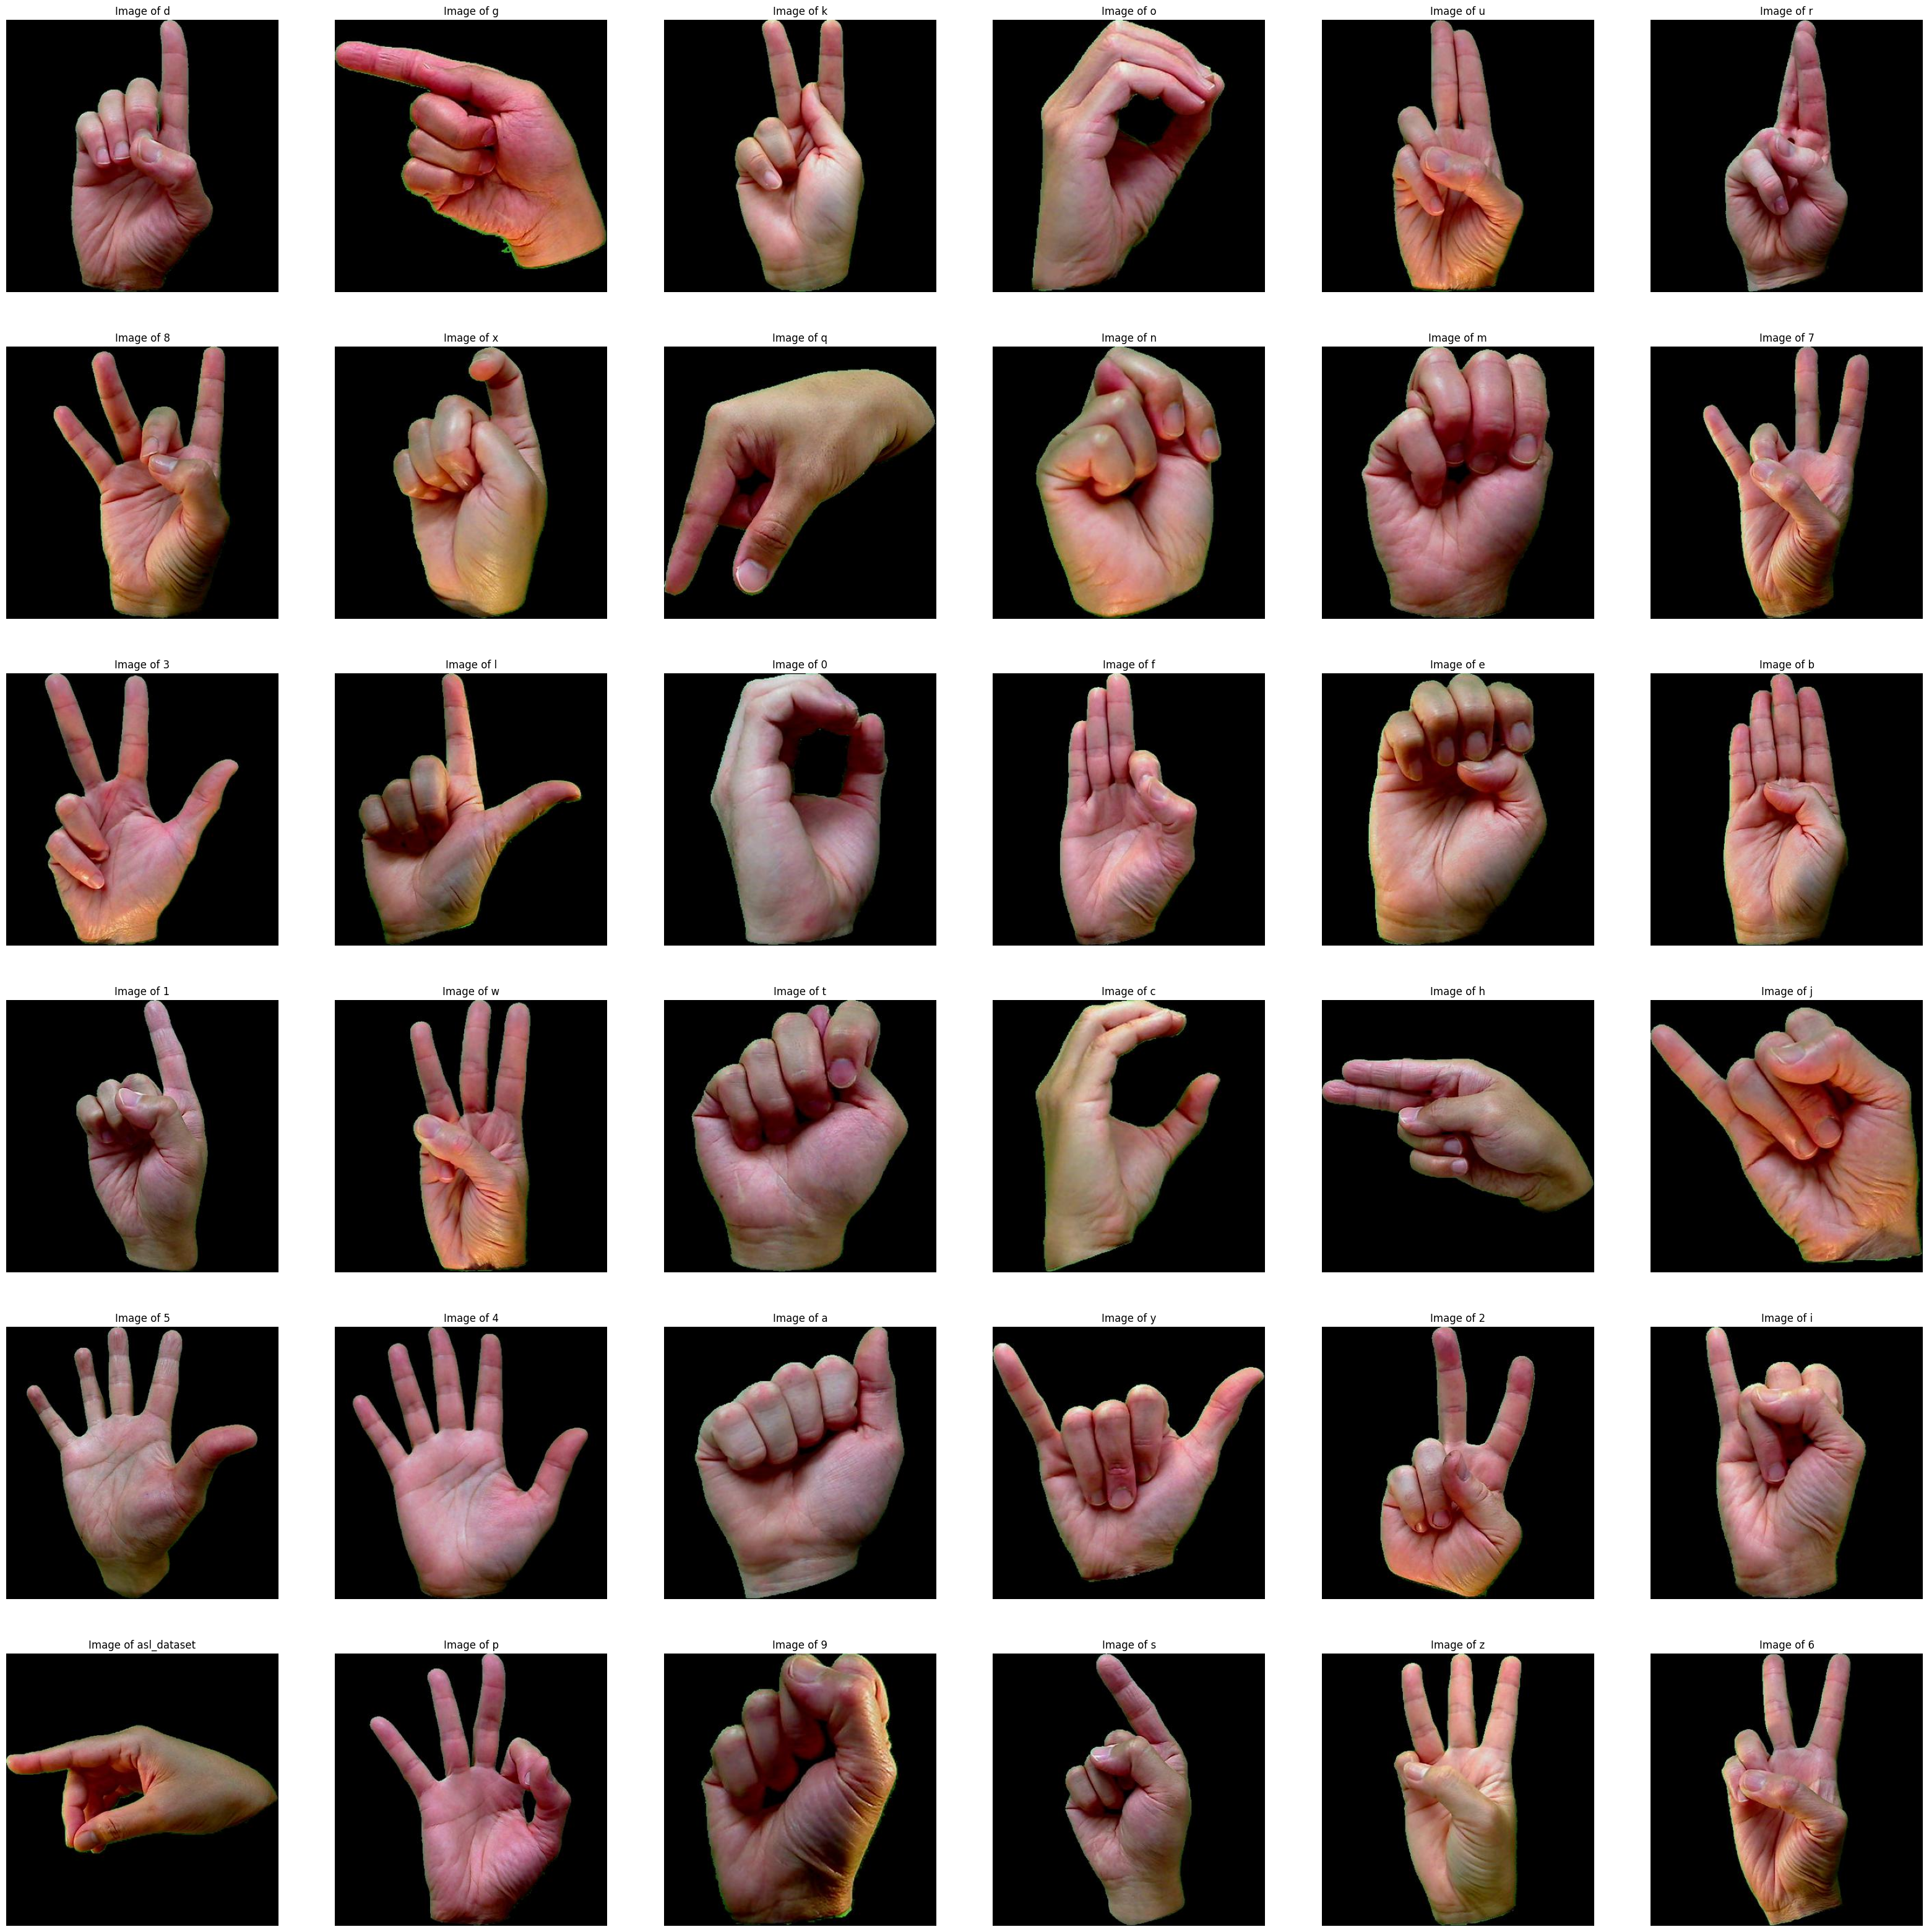

In [ ]:
plt.figure(figsize=(40,40))
for i in range(36):
    img = plt.imread(paths[i])
    plt.subplot(6,6, i + 1)
    plt.imshow(img)
    plt.title(f"Image of {directories[i]}")
    plt.axis("off")

In [ ]:
splitfolders.ratio('/kaggle/input/asl-dataset/asl_dataset', output="/kaggle/working/", seed=1337, ratio=(0.8, 0.2))

Copying files: 2515 files [00:00, 7603.56 files/s]


We have got an extra class with the name **asl_dataset** which is the main directory so we are going to remove it using the **shutil** library

In [ ]:
import shutil
shutil.rmtree("/kaggle/working/train/asl_dataset")
shutil.rmtree("/kaggle/working/val/asl_dataset")

### Scaling Data With Image data generator

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
test_gen = ImageDataGenerator(rescale = 1.0 / 255)

### Getting Data with flow from directory

In [ ]:
train_generator = datagen.flow_from_directory(
    "/kaggle/working/train",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical",
)
validation_generator = test_gen.flow_from_directory(
    "/kaggle/working/val",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical",
    shuffle = False,
)

Found 2012 images belonging to 36 classes.
Found 503 images belonging to 36 classes.


## Building Model

In [ ]:
model = Sequential([
    Conv2D(input_shape=(150,150,3),filters = 32,kernel_size=(3,3),padding = 'same',activation='relu'),
    MaxPool2D(),
    Conv2D(64,kernel_size=(3,3),padding = 'same',activation='relu'),
    MaxPool2D(),
    Conv2D(128,kernel_size=(3,3),padding = 'same',activation='relu'),
    MaxPool2D(),
    Conv2D(256,kernel_size=(3,3),padding = 'same',activation='relu'),
    MaxPool2D(),
    BatchNormalization(),
    Conv2D(512,kernel_size=(3,3),padding = 'same',activation='relu'),
    MaxPool2D(),

    Flatten(name='flatten'),
    Dense(36, activation = 'softmax')

])
model.summary()

model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 18, 18, 128)       0

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

history = model.fit(train_generator, steps_per_epoch = 2012 // 32,
                    validation_steps = 503 // 32,
                    epochs = 100,
                    validation_data = validation_generator,
                   callbacks=[early_stopping])

Epoch 1/100
62/62 [==============================] - 13s 109ms/step - loss: 1.4419 - accuracy: 0.6263 - val_loss: 3.1905 - val_accuracy: 0.7979
Epoch 2/100
62/62 [==============================] - 5s 75ms/step - loss: 0.3062 - accuracy: 0.9111 - val_loss: 3.2584 - val_accuracy: 0.8313
Epoch 3/100
62/62 [==============================] - 6s 93ms/step - loss: 0.1425 - accuracy: 0.9535 - val_loss: 2.9382 - val_accuracy: 0.8708
Epoch 4/100
62/62 [==============================] - 5s 74ms/step - loss: 0.0998 - accuracy: 0.9667 - val_loss: 3.0570 - val_accuracy: 0.8396
Epoch 5/100
62/62 [==============================] - 5s 88ms/step - loss: 0.0926 - accuracy: 0.9717 - val_loss: 1.8076 - val_accuracy: 0.8625
Epoch 6/100
62/62 [==============================] - 4s 72ms/step - loss: 0.0776 - accuracy: 0.9813 - val_loss: 2.7023 - val_accuracy: 0.8146
Epoch 7/100
62/62 [==============================] - 4s 65ms/step - loss: 0.0506 - accuracy: 0.9884 - val_loss: 1.5215 - val_accuracy: 0.9146
Epoc

## Evaluating The Model

### Accuracy Score

In [ ]:
evaluation_results = model.evaluate(validation_generator)
print("Test Loss:", evaluation_results[0])
print("Test Accuracy:", evaluation_results[1])

16/16 [==============================] - 2s 138ms/step - loss: 3.2147 - accuracy: 0.7227
Test Loss: 3.2146623134613037
Test Accuracy: 0.7226639986038208


### F1 Score

In [ ]:
from sklearn.metrics import f1_score

predIdxs = model.predict_generator(validation_generator)

predIdxs = np.argmax(predIdxs, axis=1)

print(f1_score(validation_generator.labels, predIdxs, average='micro'))

0.7226640159045724


### Accuracy Visualisation

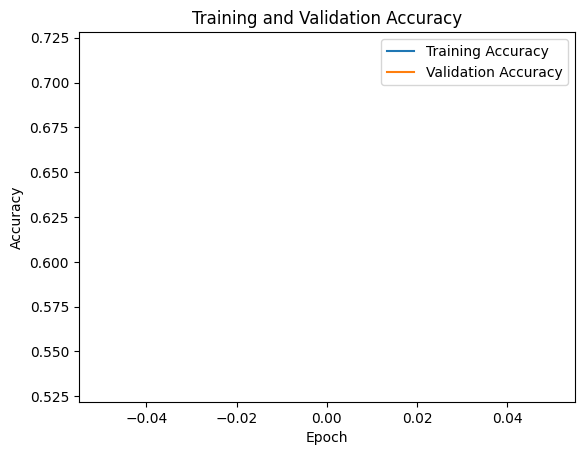

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

### Samples Visualisation

In [ ]:
directories= [str(i) for i in range(10)]
l=[]
for x in range(26):
    l.append(chr(x+97))
directories = directories + l

In [ ]:
dir = "/kaggle/input/asl-dataset/asl_dataset/"
paths = []
labels = []
for directory in directories:
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) >= 2:
        chosen_images = random.sample(image_files, 1)
        for image in chosen_images:
            labels.append(directory)
            image_path = os.path.join(dir + directory, image)
            paths.append(image_path)